# Financial Data Analysis - Stock Price Prediction
**금융 자료 분석 - 주식 가격 예측**

**사용 자료**
- S&P 500에 포함된 기업의 주식 목록
  - S&P 500 지수는 국제 신용평가기관인 미국의 Standard and Poors(S&P)이 작성한 주가 지수이다. 다우존스 지수와 마찬가지로 뉴욕증권거래소에 상장된 기업의 주가 지수이다.
  - 지수 산정에 포함되는 기업수는 시가총액 기준 상위 500개이고 포함된 주식수는 505개이다. S&P 500에 포함된 주식수가 505개인 이유는 5개 기업이 두 개 클래스로 나눠진 주식을 가지고 있기 때문이다. 이 두 클래스는 의결권이 다르다.
  - 지수에 포함된 주식이 전체 미국 주식시장 시가총액의 80%를 차지하기 때문에 시장 전체 동향 파악이 용이하다.
- 주식 가격 정보
  - S&P 500 기업의 일별 주식 정보를 가져온다.
  - 2000년 1월 1일부터 현재까지의 주식 정보를 수집함.
  - 일별 주식 정보는 날짜(date), 시작가(open), 최고가(high), 최저가(low), 마감가(close), 체결량(volume)을 포함한다.
 
**자료 종류**
- 시계열(time series)

**자료 특징**
- S&P 500 지수는 장기적으로 우상향의 그래프를 보여준다. 하지만 단기적으로 개별 기업 주식 가격의 움직임을 예측하기는 힘들다.
- 단기 주식 가격의 움직임은 일반적으로 랜덤 워크(random walk)라고 알려져있다. 랜덤 워크란 미래 가격변동을 예상하는데 과거의 가격이 아무 쓸모없으며 증권가격은 시장에 나오는 새 정보와의 상호작용을 반영한다는 가설이다.

**의문점**
- 램덤 워크 가설이 맞는가?
- 전체 주식 시장 동향을 기반으로 단기 미래 주식 가격의 변동을 예측 할 순 없을까?

**프로젝트 환경**
- Python 3.6
- Pandas, Numpy, Beautiful Soup 4, Scikit-learn

**프로젝트 요약**
- Multi-class Classification: 특정 주식을 살지, 팔지, 보유해야 할 것인지 예측하자.
  - Supervised Learning에서 분류(classification) 문제
  - Features: S&P 500 기업들의 일별 주식 가격 변화율
  - Target: 예측할 주식을 세 개의 분류 클래스로 설정: buy(1), sell(-1), hold(0)
  - 목표 정확도(accuracy) > 0.33(무작위 확률)
  - 분류 알고리즘
  - Linear SVC, K-Neighbors Classifier, Random Forest Classifier
  - 파라미터 값은 GridSerchCV를 통해 자동으로 선정
  - 고려 사항
    - 자료 크기를 어떻게 설정할 것인가?
      - 2000년 부터의 자료가 전부 필요한 것인지 의문이다.
      - 최근 몇 년의 자료만 사용했을 시 예측 성능이 더 좋지 않을까?
    - 시계열 자료를 학습하기 위해 test와 train data를 구분 할 시 chronological order를 고려하지 않고 무작위로 shuffle해도 되는 건가?
    - 하나의 클래스만 예측한 경우보다 높은 정확도가 필요하다. 
      - 단순히 buy라고 예측했을 때의 정확도보다 분류 모델을 적용한 예측도를 높여보자.
    - Precision-Recall로 예측 성능을 평가하는 것이 더욱 정확하다.
    - Feature의 수를 줄여서 예측 성능을 높을 순 없을까?
      - 주성분 분석(PCA)이나 군집화(clustering)을 통해 예측할 주식과 관련이 높은 feature만 선정하면 예측 성능을 높일 수 있을 것으로 예상함.
- 특정 주식의 미래 가격을 예측하자. (미구현)
  - Supervised Learning의 회귀(regression) 문제
  - Recurrent Neural Network의 한 종류인 Long Short-Term Memory (LSTM) 알고리즘을 사용해 주식의 미래 가격을 예측하자.

**References**
- 파이썬 데이터 분석 3종세트
  - https://www.slideshare.net/itproman35/3-65232120
  - https://datascienceschool.net/view-notebook/996d8538181e41729f7b6464789fa050/
- Approaching (Almost) Any Machine Learning Problem
  - https://www.linkedin.com/pulse/approaching-almost-any-machine-learning-problem-abhishek-thakur
- Precision-Recall
  - http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html
- Visualizing the stock market structure
  - http://scikit-learn.org/stable/auto_examples/applications/plot_stock_market.html
- Stock Price Prediction by Siraj Raval
  - https://www.youtube.com/watch?v=SSu00IRRraY
- Time Series Analysis: A Primer
  - http://www.kdnuggets.com/2017/01/time-series-analysis-primer.html
- RNN(LSTM) Examples
  - How to Predict Stock Prices Easily - Intro to Deep Learning #7 by Siraj Raval
    - https://www.youtube.com/watch?v=ftMq5ps503w
    - https://github.com/llSourcell/How-to-Predict-Stock-Prices-Easily-Demo
    - https://github.com/etai83/lstm_stock_prediction/blob/master/.ipynb_checkpoints/GOOGLE%20stock%20prediction-checkpoint.ipynb
    - https://github.com/AndysDeepAbstractions/How-to-Predict-Stock-Prices-Easily-Demo/blob/master/lstm.py
  - Deep Learning Zero to All by Sung Hun Kim
    - https://www.youtube.com/watch?v=odMGK7pwTqY&feature=youtu.be
    - https://github.com/hunkim/DeepLearningZeroToAll/blob/master/lab-12-5-rnn_stock_prediction.py
    - https://docs.google.com/presentation/d/1UpZVnOvouIbXd0MAFBltSra5rRpsiJ-UyBUKGCrfYoo/edit#slide=id.g1ed9069b96_0_371
    - http://sebastianraschka.com/Articles/2014_about_feature_scaling.html#about-standardization
 


# Project Details
## Data Preparation

In [4]:
# Beautiful Soup 4: pulling data from HTML or XML.
import bs4 as bs
# The pickle module implements binary protocols for serializing and de-serializing a Python object structure.
import pickle
# HTTP library
import requests
# Miscellaneous operating system interfaces
import os
# Basic date and time types
import datetime as dt
# Remote data access for pandas
import pandas_datareader.data as web
# Python Data Analysis Library
import pandas as pd

pd.set_option('display.width', 1000)


def save_sp500_tickers():
    """Step 1. Data Selection
    Getting tickers from S&P 500 companies, referencing the S&P 500 list from wikipedia.
    A ticker symbol is an abbreviation used to uniquely identify a particular stock on a stock market.
    The S&P 500 stock market index, maintained by S&P Dow Jones Indices,
    comprises 505 common stocks issued by 500 large-cap companies and traded on American stock exchanges,
    and covers about 80 percent of the American equity market by capitalization.
    """
    resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    # Convert the html source code into python objects, lxml is a parser.
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    # Find 'wikitable sortable' class in the HTML source code.
    table = soup.find('table', {'class': 'wikitable sortable'})
    # Define a list for saving S&P 500 ticker.
    tickers = []

    # Start from 1 to ignore the table header. 'tr' means table row.
    for row in table.findAll('tr')[1:]:
        # First column is the ticker of companies. 'td' means table data.
        ticker = row.findAll('td')[0].text
        # Append each ticker to the 'tickers' list.
        tickers.append(ticker)

    # Pickle the 'sp500tickers' list using the highest protocol available.
    # Open a pickle file in binary mode: “wb” to write it, and “rb” to read it.
    with open('sp500tickers.pickle', 'wb') as f:
        # Write a pickled representation of obj to the open file object file.
        pickle.dump(tickers, f)

    # print(tickers)

    return tickers


def get_data_from_google(reload_sp500=False):
    """Step 2-1. Data Preprocessing - Integration
    Gathering all company's, listed in the S&P 500, stock price data from Google finance.
    Downloaded 502 lists of stock price data out of 505 common stocks.
    Need to fix an error: couldn't access LMT, NWL, and NBL data.
    pandas_datareader._utils.RemoteDataError: Unable to read URL:
    http://www.google.com/finance/historical?q=LMT&startdate=Jan+01%2C+2000&enddate=Dec+31%2C+2016&output=csv
    """
    if reload_sp500:
        # Re-pull the S&P 500 list when reload_sp500=True
        tickers = save_sp500_tickers()
    else:
        with open('sp500tickers.pickle', 'rb') as f:
            tickers = pickle.load(f)

    if not os.path.exists('data'):
        os.mkdir('data')

    # Set start and end date range for pulling data
    start = dt.datetime(2000, 1, 1)
    end = dt.datetime(2017, 5, 29)

    for ticker in tickers:
        # 'ticker' is an items in 'tickers' list
        print(ticker)
        try:
            # 'format' performs a string formatting operation
            if not os.path.exists('data/{}.csv'.format(ticker)):
                df = web.DataReader(ticker, 'google', start, end)
                df.to_csv('data/{}.csv'.format(ticker))
            else:
                print("Already have {}.csv".format(ticker))
        except:
            print("Can't load {} data.".format(ticker))


def compile_data():
    """Step 2-2. Data Preprocessing - Integration / Cleaning
    In this step, multiple csv files merged into one main csv file.
    Compiling all the stock price into one data frame, and removing unnecessary columns.
    """
    with open('sp500tickers.pickle', 'rb') as f:
        tickers = pickle.load(f)

    # DataFrame is 2D size-mutable, potentially heterogeneous tabular data structure with labeled axes (rows & columns)
    # Create csv for daily close values per ticker
    main_df = pd.DataFrame()

    # 'enumerate' is a built-in function, it returns an enumerate object
    for count, ticker in enumerate(tickers):
        try:
            df = pd.read_csv('data/{}.csv'.format(ticker))
            # Set the DataFrame index (row labels) using one or more existing columns. By default yields a new object.
            # The inplace parameter is for modifying the DataFrame in place (do not create a new object)
            # Set 'Date' as an index key
            df.set_index('Date', inplace=True)
            # 'columns' parameter: dict-like or functions are transformations to apply to that axis’ values
            df.rename(columns={'Close': ticker}, inplace=True)
            # Drop requested axis without creating a new object (0: row axis, 1: columns axis)
            df.drop(['Open', 'High', 'Low', 'Volume'], 1, inplace=True)
            if main_df.empty:
                main_df = df
            else:
                # 'how' is a methods of join {‘left’, ‘right’, ‘outer’, ‘inner’}, default: ‘left’
                main_df = main_df.join(df, how='outer')
        except:
            pass
        if count % 10 == 0:
            print(count)
    print(main_df.tail())
    main_df.to_csv('sp500-joined-closes.csv')

    # Create sp500 joined csv file, including daily closes, High-Low pct. change, and Open-Close pct. change
    main_df = pd.DataFrame()

    for count, ticker in enumerate(tickers):
        try:
            df = pd.read_csv('data/{}.csv'.format(ticker))
            df.set_index('Date', inplace=True)
            # Daily High-Low percentage difference per ticker
            df['{}_HL_pct_diff'.format(ticker)] = (df['High'] - df['Low']) / df['Low']
            # Daily Close-Open percentage change per ticker
            df['{}_daily_pct_chg'.format(ticker)] = (df['Close'] - df['Open']) / df['Open']
            df.rename(columns={'Close': '{}_Close'.format(ticker)}, inplace=True)
            df.rename(columns={'Volume': '{}_Volume'.format(ticker)}, inplace=True)
            df.drop(['Open', 'High', 'Low'], 1, inplace=True)
            if main_df.empty:
                main_df = df
            else:
                main_df = main_df.join(df, how='outer')
        except:
            pass
        if count % 10 == 0:
            print(count)
    print(main_df.tail())
    main_df.to_csv('sp500-joined.csv')


# save_sp500_tickers()
# get_data_from_google()
# compile_data()


['MMM',
 'ABT',
 'ABBV',
 'ACN',
 'ATVI',
 'AYI',
 'ADBE',
 'AMD',
 'AAP',
 'AES',
 'AET',
 'AMG',
 'AFL',
 'A',
 'APD',
 'AKAM',
 'ALK',
 'ALB',
 'ARE',
 'ALXN',
 'ALLE',
 'AGN',
 'ADS',
 'LNT',
 'ALL',
 'GOOGL',
 'GOOG',
 'MO',
 'AMZN',
 'AEE',
 'AAL',
 'AEP',
 'AXP',
 'AIG',
 'AMT',
 'AWK',
 'AMP',
 'ABC',
 'AME',
 'AMGN',
 'APH',
 'APC',
 'ADI',
 'ANTM',
 'AON',
 'APA',
 'AIV',
 'AAPL',
 'AMAT',
 'ADM',
 'ARNC',
 'AJG',
 'AIZ',
 'T',
 'ADSK',
 'ADP',
 'AN',
 'AZO',
 'AVB',
 'AVY',
 'BHI',
 'BLL',
 'BAC',
 'BK',
 'BCR',
 'BAX',
 'BBT',
 'BDX',
 'BBBY',
 'BRK.B',
 'BBY',
 'BIIB',
 'BLK',
 'HRB',
 'BA',
 'BWA',
 'BXP',
 'BSX',
 'BMY',
 'AVGO',
 'BF.B',
 'CHRW',
 'CA',
 'COG',
 'CPB',
 'COF',
 'CAH',
 'CBOE',
 'KMX',
 'CCL',
 'CAT',
 'CBG',
 'CBS',
 'CELG',
 'CNC',
 'CNP',
 'CTL',
 'CERN',
 'CF',
 'SCHW',
 'CHTR',
 'CHK',
 'CVX',
 'CMG',
 'CB',
 'CHD',
 'CI',
 'XEC',
 'CINF',
 'CTAS',
 'CSCO',
 'C',
 'CFG',
 'CTXS',
 'CLX',
 'CME',
 'CMS',
 'COH',
 'KO',
 'CTSH',
 'CL',
 'CMCSA',
 'CMA

## Visualization - Looking for a pattern

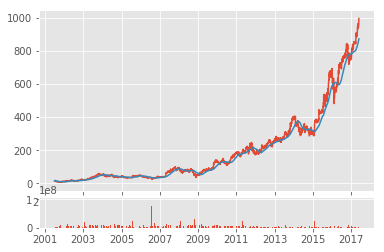

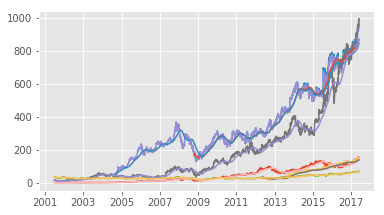

/usr/local/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


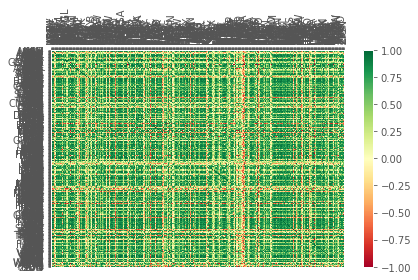

In [3]:
# Python 2D plotting library
from matplotlib import style
# Pyplot provides a MATLAB-like plotting framework
import matplotlib.pyplot as plt
# Fundamental package for scientific computing
import numpy as np
# Python Data Analysis Library
import pandas as pd

# ggplot is a plotting system for Python based on R's ggplot2
style.use('ggplot')

pd.set_option('display.width', 1000)


def visualize_ticker(ticker):
    """Visualizing data and searching for patterns.
    
    """
    df = pd.read_csv('sp500-joined.csv', parse_dates=True, index_col=0)

    # 100 days rolling moving average
    df['{}_100MA'.format(ticker)] = df['{}_Close'.format(ticker)].rolling(window=100, min_periods=0).mean()

    ax1 = plt.subplot2grid((6, 1), (0, 0), rowspan=5, colspan=1)
    ax2 = plt.subplot2grid((6, 1), (5, 0), rowspan=1, colspan=1, sharex=ax1)

    ax1.plot(df.index, df['{}_Close'.format(ticker)])
    ax1.plot(df.index, df['{}_100MA'.format(ticker)])
    ax2.bar(df.index, df['{}_Volume'.format(ticker)])

    plt.show()


def visualize_tickers(*args):
    """Visualizing data and searching for patterns.
    Create linear plot graphs for several stocks 
    """
    df = pd.read_csv('sp500-joined.csv', parse_dates=True, index_col=0)

    tickers = [t for t in args]
    tickers_100ma, tickers_close, tickers_volume = [], [], []

    # 100 days rolling moving average
    for ticker in tickers:
        df['{}_100MA'.format(ticker)] = df['{}_Close'.format(ticker)].rolling(window=100, min_periods=0).mean()

        tickers_100ma.append('{}_100MA'.format(ticker))
        tickers_close.append('{}_Close'.format(ticker))

    ax1 = plt.subplot2grid((6, 1), (0, 0), rowspan=5, colspan=1)

    ax1.plot(df.index, df[tickers_close])
    ax1.plot(df.index, df[tickers_100ma])

    plt.show()


def visualize_corr():
    """Visualizing data and searching for patterns.
    Building a correlation heatmap of S&P 500 stock prices.
    """
    df = pd.read_csv('sp500-joined-closes.csv')

    # Compute pairwise correlation of columns, excluding NA/null values
    df_corr = df.corr()
    df_corr.to_csv('sp500corr.csv')

    # Extract values from the corr table, and assign it as Numpy array
    data1 = df_corr.values

    # Define fig1 as matplotlib figure
    fig1 = plt.figure()

    # Add subplot in fig1, 111 means height, width, and plot number
    ax1 = fig1.add_subplot(111)

    # Set a color map of heatmap, pcolor: plot color, cmap: colormap
    heatmap1 = ax1.pcolor(data1, cmap=plt.cm.RdYlGn)

    # Add colorbar to the subplot
    fig1.colorbar(heatmap1)

    # Set ticks for x and y axis
    # Numpy.arange: return evenly spaced values within a given interval
    # 0.5 is the middle (0 to 1)
    # minor=False means disable minor ticks from axis
    ax1.set_xticks(np.arange(data1.shape[0]) + 0.5, minor=False)
    ax1.set_yticks(np.arange(data1.shape[1]) + 0.5, minor=False)

    # Flip y axis for better readability
    ax1.invert_yaxis()

    # Move x axis to the top of subplot from the bottom
    ax1.xaxis.tick_top()

    # Assign labels, df_corr.columns and df_corr.index are identical
    column_labels = df_corr.columns
    row_labels = df_corr.index

    # Set tick labels for x and y axis
    ax1.set_xticklabels(column_labels)
    ax1.set_yticklabels(row_labels)

    # Rotate x axis tick labels vertically
    plt.xticks(rotation=90)

    # Set the heatmap's color range from -1 to 1, clim: color limit
    heatmap1.set_clim(-1, 1)

    # Automatically adjust the subplot, so that fits into the figure
    plt.tight_layout()

    # Save the figure as a file
    # plt.savefig('correlations.png', dpi=300)

    # Display the figure
    plt.show()


# Visualize one stock with 100 days moving average
visualize_ticker('AMZN')

# Visualize Big 5 Tech. Companies
visualize_tickers('AAPL', 'GOOGL', 'GOOG', 'AMZN', 'FB', 'MSFT')

# Visualize heatmap of stock correlation
visualize_corr()


## Prediction - Multi-class Classification

In [4]:
from collections import Counter
from datetime import datetime
import pandas as pd
import numpy as np
from sklearn import svm, neighbors
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from statistics import mean

pd.set_option('display.width', 1000)


def prep_manipulation(ticker):
    """Read S&P 500 close price data and manipulate and normalize for preprocessing
    """
    # How many days in the future we need prices for
    days = 5
    # Read daily close prices of all stocks, index is 'Date'
    df = pd.read_csv('sp500-joined-closes.csv', index_col=0)
    # Convert ticker column names into a list
    tickers = df.columns.values.tolist()
    # Replace NA/NaN values by 0
    df.fillna(0, inplace=True)

    # Normalization: add new columns of pct. change values for the next i days
    for i in range(1, days + 1):
        # Pct. change within next i days and today's price = (price in i days - today's price) / today's price
        # Shift index by -i periods (shift up the column by i rows)
        df['{}_{}D'.format(ticker, i)] = (df[ticker].shift(-i) - df[ticker]) / df[ticker]

    # Replace NA/NaN values by 0
    df.fillna(0, inplace=True)

    return tickers, df, days


def label_classes(*args):
    """Target Labeling criteria
    """
    cols = [c for c in args]
    requirement = 0.02

    for col in cols:
        if col > requirement:
            return 1
        if col < -requirement:
            return -1

    return 0


def prep_map_labels(ticker):
    """Mapping Target Labels
    """
    tickers, df, days = prep_manipulation(ticker)

    df['{}_target'.format(ticker)] = \
        list(map(label_classes, *[df['{}_{}D'.format(ticker, i)] for i in range(1, days + 1)]))

    # print(df['{}_target'.format(ticker)])

    vals = df['{}_target'.format(ticker)].values.tolist()
    # Change vals integer into string
    str_vals = [str(i) for i in vals]
    print('Target Label Counts:', Counter(str_vals))

    # Cleaning data
    df.fillna(0, inplace=True)
    df = df.replace([np.inf, -np.inf], np.nan)
    df.dropna(inplace=True)

    # Percent change over given number of periods.
    df_vals = df[[ticker for ticker in tickers]].pct_change(periods=1)
    df_vals = df_vals.replace([np.inf, -np.inf], 0)
    df_vals.fillna(0, inplace=True)

    # Features: daily pct. change of all S&P 500 stocks (may need to reduce no. of features, PCA analysis or clustering)
    X = df_vals.values
    # Target:
    y = df['{}_target'.format(ticker)].values

    return X, y, df


def classification(ticker):
    """Classify a specific stock
    """
    print(ticker)

    X, y, df = prep_map_labels(ticker)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    clf1 = svm.LinearSVC()
    clf2 = neighbors.KNeighborsClassifier()
    clf3 = RandomForestClassifier()
    # n_jobs: The no. of jobs to run in parallel for fit. If -1, then the number of jobs is set to the number of cores.
    # I don't see the difference after applying n_jobs, what's the problem?
    eclf = VotingClassifier(estimators=[('lsvc', clf1), ('knc', clf2), ('rfc', clf3)], voting='hard', n_jobs=-1)

    params = {}

    """
    #PCA
    pca = PCA(n_components=10)
    pca.fit(X_train)
    X_train = pca.transform(X_train)
    pca.fit(X_test)
    X_test = pca.transform(X_test)
    """

    grid = GridSearchCV(estimator=eclf, param_grid=params, cv=5)
    grid = grid.fit(X_train, y_train)

    """
    tscv = TimeSeriesSplit(n_splits=3)
    for train_index, test_index in tscv.split(X):
        print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
    """

    # eclf.fit(X_train, y_train)
    # use for loop for testing each classifiers

    predictions = grid.predict(X_test)
    print('Predicted Target Label Counts:', Counter(predictions))

    accuracy = grid.score(X_test, y_test)
    print('Accuracy:', accuracy)

    return accuracy

    # need to add precision-recall curve
    # http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html


def classification_all():
    """Classify all S&P 500 stocks 
    """
    df = pd.read_csv('sp500-joined-closes.csv', index_col=0)
    tickers = df.columns.values.tolist()
    print(tickers)

    accuracies = []

    for count, ticker in tickers:
        try:
            accuracy = classification(ticker)
            accuracies.append(accuracy)
            # print("{} accuracy: {}".format(ticker, accuracy))
            print(count)
        except:
            print("{} has only one class in label".format(ticker))

    print("Average accuracy ({} stocks): {}".format(count, mean(accuracies)))


start = datetime.now()
classification('AMZN')
print(datetime.now() - start)

# classification_all()  # It takes too much time, n_jobs doesn't work


AMZN
Target Label Counts: Counter({'1': 1883, '-1': 1539, '0': 956})
Predicted Target Label Counts: Counter({-1: 623, 1: 507, 0: 182})
Accuracy: 0.457317073171
0:00:56.004744
